# Movies recomender

data from https://grouplens.org/datasets/movielens/latest/

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

In [2]:
df_movies = pd.read_csv('../lab/data/movies.csv')
df_ratings = pd.read_csv('../lab/data/ratings.csv')

## 1.1 EDA

### a) general EDA, data preparation

In [3]:
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [5]:
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [7]:
# transfroming timestamp to datetime and keeping just year
# dropping timestamp column

df_ratings['year'] = pd.to_datetime(df_ratings['timestamp'], unit='s').dt.year
df_ratings = df_ratings.drop('timestamp', axis=1)

In [8]:
df_ratings.head(3)

,userId,movieId,rating,year
0,1,307,3.5,2009
1,1,481,3.5,2009
2,1,1091,1.5,2009


In [9]:
# 'year' column contains years from 1995 - 2018 as expected
df_ratings['year'].unique()

array([2009, 2007, 1999, 2005, 2006, 2008, 1996, 1997, 2000, 2014, 2015,
       2018, 2016, 2017, 2013, 1998, 2012, 2003, 2001, 2004, 2002, 2010,
       2011, 1995], dtype=int64)

### b) Which are the 10 most rated movies?

In [10]:
# sorting out 10 top indexes with most value counts
df_ratings['movieId'].value_counts().sort_values(ascending=False).head(10)

318     97999
356     97040
296     92406
593     87899
2571    84545
260     81815
480     76451
527     71516
110     68803
1       68469
Name: movieId, dtype: int64

In [11]:
# saving movieIds for the most rated movies
most_rated_movies_Id = df_ratings['movieId'].value_counts().sort_values(ascending=False).head(10).index
most_rated_movies_Id

Int64Index([318, 356, 296, 593, 2571, 260, 480, 527, 110, 1], dtype='int64')

In [12]:
# printing out the top 10 most rated movies 
# getting titles based on movieIds in most_rated_movies
# .values[0] to get a nice print-out of only title and not Name and dtype

print('The most rated movies are:')
for i, Id in enumerate(most_rated_movies_Id, 1):
    print(f"{i}. {df_movies.loc[df_movies['movieId'] == Id]['title'].values[0]}")

The most rated movies are:
1. Shawshank Redemption, The (1994)
2. Forrest Gump (1994)
3. Pulp Fiction (1994)
4. Silence of the Lambs, The (1991)
5. Matrix, The (1999)
6. Star Wars: Episode IV - A New Hope (1977)
7. Jurassic Park (1993)
8. Schindler's List (1993)
9. Braveheart (1995)
10. Toy Story (1995)


### c) What is the average rating for the 10 most rated movies?

In [13]:
for Id in most_rated_movies_Id:
    title = df_movies.loc[df_movies['movieId'] == Id]['title'].values[0]
    mean_rating = df_ratings.loc[df_ratings['movieId'] == Id, 'rating'].mean()
    print(f"Average rating for {title} is {mean_rating:.2f}")

Average rating for Shawshank Redemption, The (1994) is 4.42
Average rating for Forrest Gump (1994) is 4.06
Average rating for Pulp Fiction (1994) is 4.17
Average rating for Silence of the Lambs, The (1991) is 4.15
Average rating for Matrix, The (1999) is 4.15
Average rating for Star Wars: Episode IV - A New Hope (1977) is 4.12
Average rating for Jurassic Park (1993) is 3.67
Average rating for Schindler's List (1993) is 4.26
Average rating for Braveheart (1995) is 4.01
Average rating for Toy Story (1995) is 3.89


### d) Plot number of films in dataset as function of year

In [14]:
# adding a new column with production year by extracting relevant string slice (4 digits within paranthesis) from column 'title'
# see that not all titles contained year, thus resulting in ~300 NaN in 'production_year column'
df_movies['production_year'] = df_movies['title'].str.extract(r'\((\d\d\d\d)\)')
df_movies.head(3)

,movieId,title,genres,production_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


In [15]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movieId          58098 non-null  int64 
 1   title            58098 non-null  object
 2   genres           58098 non-null  object
 3   production_year  57771 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


<Axes: xlabel='Production year', ylabel='Number of movies in dataset'>

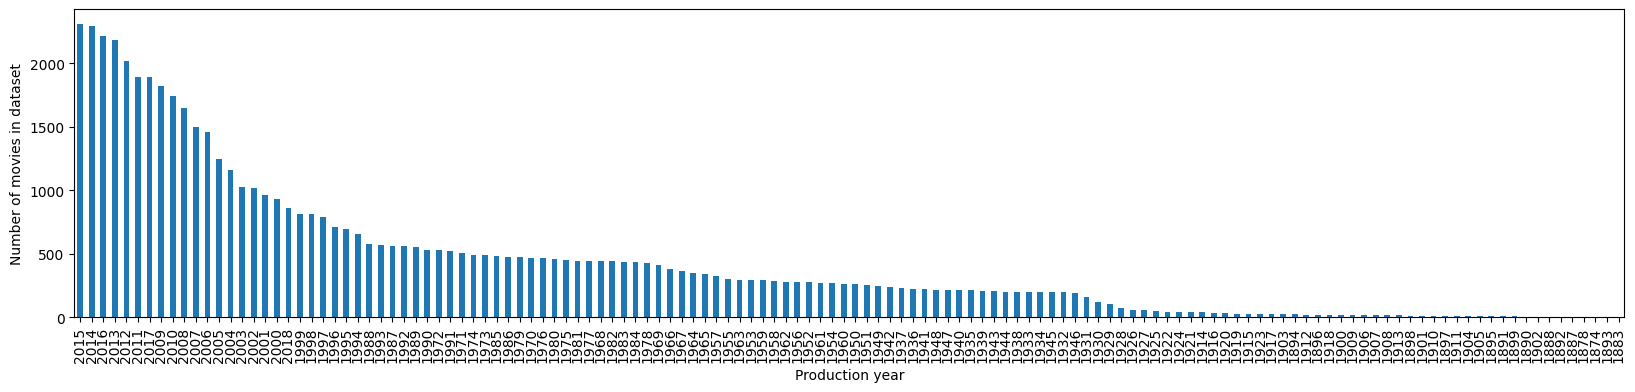

In [16]:
df_movies["production_year"].value_counts().plot(
    kind="bar",
    figsize=(20, 4),
    xlabel="Production year",
    ylabel="Number of movies in dataset",
)


### e) Plot number of ratings as function of movie ID

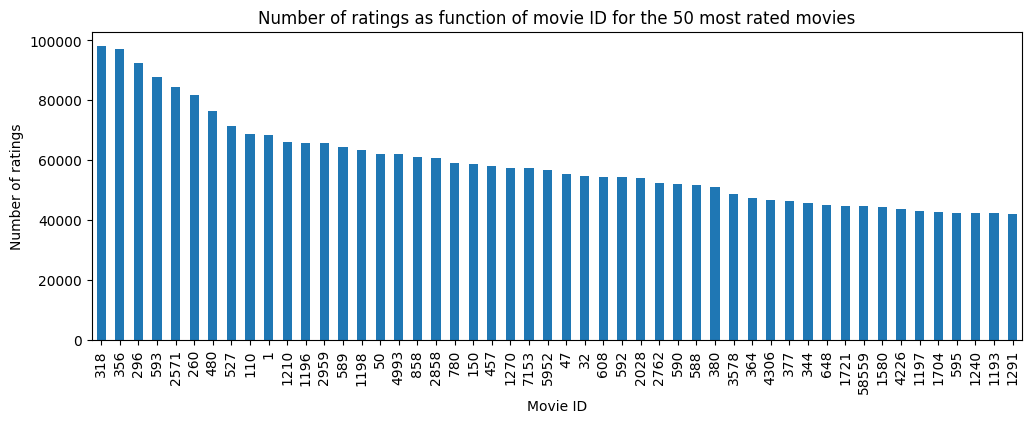

In [17]:
df_ratings["movieId"].value_counts()[:50].plot(
    kind="bar",
    figsize=(12, 4),
    xlabel="Movie ID",
    ylabel="Number of ratings",
    title="Number of ratings as function of movie ID for the 50 most rated movies",
);

### f) Plot average ratings for the 10 most rated movies

In [18]:
# create list of titles and average ratings for the 10 most rated movies
most_rated_movies_title = []
most_rated_movies_mean_rating = []

for Id in most_rated_movies_Id:
    title = df_movies.loc[df_movies['movieId'] == Id, 'title'].values[0]
    most_rated_movies_title.append(title)

    mean_rating = df_ratings.loc[df_ratings['movieId'] == Id, 'rating'].mean()
    most_rated_movies_mean_rating.append(mean_rating)

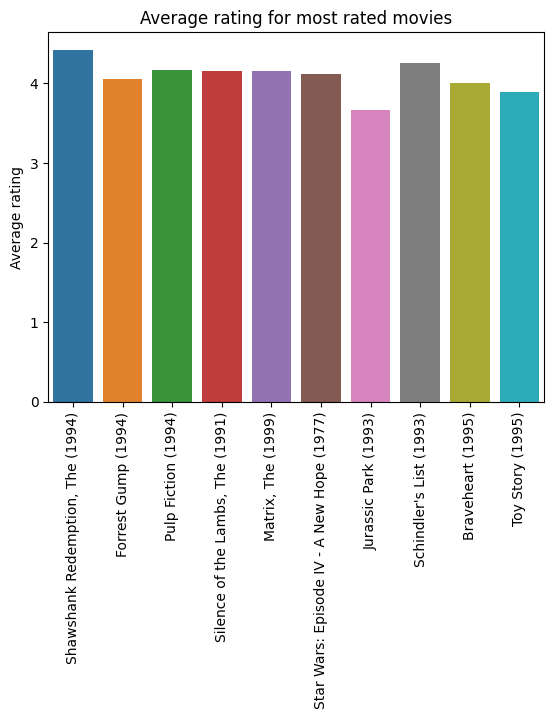

In [19]:
# plot
ax = sns.barplot(x=most_rated_movies_title, y=most_rated_movies_mean_rating)
ax.set(ylabel = 'Average rating', title = 'Average rating for most rated movies')
ax.set_xticklabels(most_rated_movies_title, rotation=90);

---
---

TODO: answer some of questions below

### g) Own question: Which 10 movies have the highest averate rating?

### h) Own question: Which users have rated the most movies?

### i) Own question: What is the most common genre in the dataset?

### j) Own question: Is there a correlationi between number of ratings and rating average for a movie?

--------------------------------------------
-------------------------------------

## 1.2 Sparse matrix

### a) Reducing ratings dataset

#### Step 1: enough ratings

In [49]:
# calculating number of movies with at least 1000 ratings, which is 1% considering mostly rated movies have ~100 000 ratings
np.sum(df_ratings['movieId'].value_counts() >= 1000)

3931

In [50]:
# saving Ids for movies with at least 1000 ratings, thus top 3931 movies
most_rated_movies_Id = df_ratings['movieId'].value_counts().sort_values(ascending=False).head(3931).index
most_rated_movies_Id

Int64Index([   318,    356,    296,    593,   2571,    260,    480,    527,
               110,      1,
            ...
              3689,   1598,  55094,   4450,   3120,   8542,   2460,   7060,
            170697,  95654],
           dtype='int64', length=3931)

In [51]:
# reduced df containing only movieId found among most rated movies
df_ratings_reduced = df_ratings.loc[df_ratings['movieId'].isin(most_rated_movies_Id)]
df_ratings_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24903574 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   year     int64  
dtypes: float64(1), int64(3)
memory usage: 950.0 MB


#### Step 2: good enough average rating

In [52]:
# furhter filtering out movies with good enough rating and saving movieId
df_temp = df_ratings_reduced.groupby(['movieId']).mean()
mask = df_temp['rating'] >= 3.0
best_rated_movies_Id = df_temp[mask].index
best_rated_movies_Id

Int64Index([     1,      2,      3,      5,      6,      7,      8,      9,
                10,     11,
            ...
            175303, 175569, 176101, 176371, 177593, 177615, 177765, 179819,
            180031, 187593],
           dtype='int64', name='movieId', length=3152)

In [53]:
# further reduced df containing only movieId with good enough ratings
df_ratings_reduced = df_ratings_reduced.loc[df_ratings_reduced['movieId'].isin(best_rated_movies_Id)]
df_ratings_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22049964 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   year     int64  
dtypes: float64(1), int64(3)
memory usage: 841.1 MB


### b) Create pivot table

In [54]:
# creating a pivot table with NaNs and replcing NaN with 0 by fillna(0)
movies_users_pivot = df_ratings_reduced.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movies_users_pivot.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,283219,283220,283221,283222,283223,283224,283225,283226,283227,283228
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
2,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


### c) Create sparse matrix

In [57]:
# creating sparse matrix from the pivot table
movies_users_matrix = csc_matrix(movies_users_pivot)

In [67]:
print(movies_users_matrix.shape)
print(movies_users_matrix[0]) 

(3152, 282010)
  (0, 3)	4.0
  (0, 9)	5.0
  (0, 13)	4.5
  (0, 14)	4.0
  (0, 21)	4.0
  (0, 24)	4.0
  (0, 26)	5.0
  (0, 30)	5.0
  (0, 31)	4.5
  (0, 36)	5.0
  (0, 40)	4.0
  (0, 41)	5.0
  (0, 49)	4.0
  (0, 52)	3.0
  (0, 53)	5.0
  (0, 54)	2.5
  (0, 56)	4.0
  (0, 60)	4.0
  (0, 65)	4.0
  (0, 68)	4.0
  (0, 69)	4.0
  (0, 71)	4.0
  (0, 72)	5.0
  (0, 77)	5.0
  (0, 97)	4.5
  :	:
  (0, 281894)	4.0
  (0, 281902)	3.5
  (0, 281905)	5.0
  (0, 281913)	4.0
  (0, 281917)	4.0
  (0, 281918)	4.0
  (0, 281927)	3.0
  (0, 281934)	3.0
  (0, 281935)	5.0
  (0, 281936)	3.0
  (0, 281937)	5.0
  (0, 281942)	3.5
  (0, 281946)	2.5
  (0, 281957)	5.0
  (0, 281963)	4.5
  (0, 281964)	5.0
  (0, 281965)	4.0
  (0, 281976)	5.0
  (0, 281977)	3.5
  (0, 281980)	5.0
  (0, 281989)	4.5
  (0, 281996)	4.0
  (0, 281998)	5.0
  (0, 282000)	4.0
  (0, 282009)	4.5
